<a href="https://colab.research.google.com/github/ArtemNechaev/stepik_nnets/blob/main/task8_translaete_de2en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Генерация кода по вопросам со StackOverflow


In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && !pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


In [ ]:
from google.colab import drive
import pickle
drive.mount('/content/drive')

with open('drive/MyDrive/de_en_vocab.pickle', 'rb') as f:
  de_en_vocab = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U spacy deep-translator
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm 

     |████████████████████████████████| 6.0 MB 5.2 MB/s 
     |████████████████████████████████| 653 kB 54.3 MB/s 
     |████████████████████████████████| 181 kB 31.4 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 451 kB 67.7 MB/s 
     |████████████████████████████████| 10.1 MB 13.1 MB/s 
     |████████████████████████████████| 97 kB 4.1 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


from torchtext.datasets import  Multi30k
from collections import OrderedDict, Counter
from deep_translator import GoogleTranslator

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe
from torchtext.datasets import Multi30k
from typing import Iterable, List
#from torchtext.data import Field, BucketIterator


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time
from tqdm import tqdm
import pickle

import zipfile
import gensim

In [ ]:
SEED = 1234

ENC_EMB_DIM = 100
DEC_EMB_DIM = 128

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!wget 'http://vectors.nlpl.eu/repository/20/45.zip'

--2022-03-27 16:54:45--  http://vectors.nlpl.eu/repository/20/45.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3764660264 (3.5G) [application/zip]
Saving to: ‘45.zip’

45.zip              100%[===================>]   3.51G  10.3MB/s    in 5m 57s  

2022-03-27 17:00:43 (10.1 MB/s) - ‘45.zip’ saved [3764660264/3764660264]



In [ ]:
!mkdir de_vectors
with zipfile.ZipFile('45.zip', 'r') as zf:
  zf.extractall('de_vectors')

w2v_de = gensim.models.KeyedVectors.load_word2vec_format('de_vectors/model.txt',binary=False, unicode_errors='replace')

In [ ]:


#import dlnlputils
#from dlnlputils.data import BeamGenerator

SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.

token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')



to_src = GoogleTranslator(source='english', target='german')
to_trg = GoogleTranslator(source='german', target='english')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]].lower())

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)


100%|██████████| 1.21M/1.21M [00:01<00:00, 642kB/s]


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

src_to_trg = torch.zeros(len(vocab_transform[SRC_LANGUAGE]), dtype=torch.long, )
with open('drive/MyDrive/de_en_vocab.pickle', 'rb') as f:
  de_en_vocab = pickle.load(f)

de_emb_weights = torch.zeros((len(vocab_transform[SRC_LANGUAGE]), ENC_EMB_DIM), dtype=torch.float)


for src_w, trg_w in de_en_vocab.items():
  src_id = vocab_transform[SRC_LANGUAGE][src_w]
  trg_id = vocab_transform[TGT_LANGUAGE][trg_w]
  if  (src_id != 0) & (trg_id == 0) & (trg_w != '<unk>') :
    vocab_transform[TGT_LANGUAGE].append_token(trg_w)
    trg_id = vocab_transform[TGT_LANGUAGE][trg_w]
  src_to_trg[src_id] = trg_id

  ##load pretrained vectors
  #if src_w in w2v_de.vocab:
    #embed = w2v_de.get_vector(src_w)
    #de_emb_weights[src_id] = torch.FloatTensor(embed)

src_to_trg = src_to_trg.to(device)
src_to_trg


Mounted at /content/drive


tensor([1605,    1,    2,  ..., 5882,    0,  103])

In [ ]:
(src_to_trg == 0).int().sum()

tensor(74)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        #src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n").lower()))
        #tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n").lower()))
        src_batch.append(src_sample)
        tgt_batch.append(tgt_sample)

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

class TranslationDataset(Dataset):
  def __init__(self, data, text_transform, src_ln, trg_ln):
    super().__init__()
    self.tensors = []
    for src, trg in data:
      self.tensors.append(
          (
            text_transform[src_ln](src.rstrip("\n").lower()),
            text_transform[trg_ln](trg.rstrip("\n").lower())
          )   
      )
  def __getitem__(self, idx):
    return self.tensors[idx]

  def __len__(self):
    return len(self.tensors)

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, emb_weights=None):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        if emb_weights != None:
          self.embedding.load_state_dict({'weight': emb_weights})
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                     
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.combine = nn.Linear(enc_hid_dim * 2 + emb_dim, enc_hid_dim * 2)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_input, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_input = [src sent len, batch size]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #forwar_trans_embed = self.embedding(src_to_trg[encoder_input])
        
        #embedded = [1, batch size, emb dim]
        #forwar_trans_embed = [src sent len, batch size, emb dim]

        #encoder_outputs = self.combine(torch.cat([encoder_outputs, forwar_trans_embed], dim = -1))
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            output, hidden, attention = self.decoder(output, hidden, src, encoder_outputs, mask)
            outputs[t] = output
            attentions[t] = attention
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            output = (trg[t] if teacher_force else top1)
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions
        

In [ ]:
INPUT_DIM = len(vocab_transform['de'])
OUTPUT_DIM = len(vocab_transform['en'])

ENC_HID_DIM = 100
DEC_HID_DIM = 100
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
PAD_IDX = PAD_IDX
SOS_IDX = BOS_IDX
EOS_IDX = EOS_IDX

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, emb_weights=None)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(18670, 100)
    (rnn): GRU(100, 100, bidirectional=True)
    (fc): Linear(in_features=200, out_features=100, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=300, out_features=100, bias=True)
    )
    (embedding): Embedding(18147, 128)
    (combine): Linear(in_features=328, out_features=200, bias=True)
    (rnn): GRU(328, 100)
    (out): Linear(in_features=428, out_features=18147, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Модель содержит {count_parameters(model):,} параметров')

Модель содержит 12,341,179 параметров


Then we define our optimizer and criterion. We have already initialized `PAD_IDX` when initializing the model, so we don't need to do it again.

In [ ]:
optimizer = optim.Adam(model.parameters())

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
sched = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src, trg = batch
        src = src.to(device)
        trg = trg.to(device)
        src_len = src.shape[0]
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg, 0.4)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        #output = output[1:].view(-1, output.shape[-1])
        #trg = trg[1:].view(-1)

        output = output[1:].permute(1,2,0)
        trg = trg[1:].permute(1,0)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, trg = batch
            src = src.to(device)
            trg = trg.to(device)

            src_len = src.shape[0]

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            #output = output[1:].view(-1, output.shape[-1])
            #trg = trg[1:].view(-1)

            output = output[1:].permute(1,2,0)
            trg = trg[1:].permute(1,0)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 50
CLIP = float('inf')

best_valid_loss = float('inf')

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_dataset = TranslationDataset( train_iter, text_transform, 'de', 'en')
train_iterator = DataLoader(train_dataset, batch_size=30, collate_fn = collate_fn)

valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
val_dataset = TranslationDataset( valid_iter, text_transform, 'de', 'en')
valid_iterator = DataLoader(val_dataset, batch_size=30, collate_fn = collate_fn)

for epoch in range(N_EPOCHS):
    
    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    sched.step(valid_loss)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'conala_model_attention_test.pt')
    
    print(f'Эпоха: {epoch+1:02} | Время: {epoch_mins}m {epoch_secs}s')
    print(f'Перплексия (обучение): {math.exp(train_loss):7.3f}')
    print(f'Перплексия (валидация): {math.exp(valid_loss):7.3f}')

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.state_dict(), 'drive/MyDrive/models/translator.pt')
model.load_state_dict(torch.load('drive/MyDrive/models/translator.pt', map_location=device))

<All keys matched successfully>

In [ ]:
test_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
test_iterator = DataLoader(test_iter, batch_size=128, collate_fn = collate_fn)

#model.load_state_dict(torch.load('conala_model_attention_test.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'Перплексия (валидация): {math.exp(test_loss):7.3f}')

Перплексия (валидация):  35.475


## Предсказание кода по вопросу

In [ ]:
def translate_sentence(model, sentence):
    model.eval()
    numericalized = text_transform['de'](sentence) 

    sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0) 
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(translation_tensor.cpu().numpy()))
    translation, attention = translation[1:], attention[1:]
    return translation, attention

def beam_search(encoder, decoder, sentence, beam_size = 5, max_len = 20):
  
  numericalized = text_transform['de'](sentence) 

  sentence_length = torch.LongTensor([len(numericalized)]).to(device) 
  src = torch.LongTensor(numericalized).unsqueeze(1).repeat(1, beam_size).to(device) 
  
  encoder_outputs, hidden = encoder(src, sentence_length)  #outputs [sent len, 1, enc hid dim * 2] #hidden = [1, dec hid dim]

  mask = (src != PAD_IDX).permute(1, 0) # beam_size x src_len

  output = src[0,:] # [beam_size]

  last_scores = torch.zeros((beam_size, 1)).to(device)
  #tensor to store decoder outputs
  outputs = torch.zeros(beam_size, max_len).to(device)
        
  #tensor to store attention
  #attentions = torch.zeros(max_len, beam_size, src.shape[0]).to(device)

  for i in range(max_len):
    dec_logits, hidden, att = decoder(output, hidden, src, encoder_outputs, mask)
    
    scores = F.log_softmax(dec_logits,1)
    ind = scores.argsort(1, descending=True)
    scores = torch.gather(scores, 1, ind)[:,:beam_size]
    ind = ind[:,:beam_size]

    scores += last_scores
    order_scores = scores.flatten().argsort(descending=True)
    if i == 0:
      output = ind.flatten()[:beam_size]
    else:
      output = ind.flatten()[order_scores][:beam_size]

    beam_ids = torch.div(order_scores[:beam_size], beam_size, rounding_mode='floor')
    hidden = hidden[beam_ids]
    outputs = outputs[beam_ids]
    last_scores = (last_scores[beam_ids] + scores.flatten()[order_scores][:beam_size].unsqueeze(1))/(outputs.count_nonzero(1).unsqueeze(1) + 1) ** 0.5

    outputs[:,i] = output
  
  return outputs




In [ ]:
model.eval()
sent = 'Ich habe einen Hund'
outputs = beam_search(model.encoder, model.decoder, sent.lower(), beam_size = 5, max_len = 20)

In [ ]:
for i in range(outputs.shape[0]):
  text = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(outputs[i].cpu().numpy()))
  print(' '.join(text))

there is a is a a dog . <eos> dog . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
there is a is a dog . <eos> dog . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
there is a dog dog a dog dog . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
there is a dog dog a dog . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
i am has a dog dog dog . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


In [ ]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<bos>'] + [t.lower() for t in token_transform['de'](candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_iter = list(train_iter)

In [ ]:
example_idx = 7

src = train_iter[example_idx][0]
trg = train_iter[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = Ein schickes Mädchen spricht mit dem Handy während sie langsam die Straße entlangschwebt.

trg = A trendy girl talking on her cellphone while gliding slowly down the street.



In [ ]:
outputs = beam_search(model.encoder, model.decoder, src.lower(), beam_size = 5, max_len = 20)
for i in range(outputs.shape[0]):
  text = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(outputs[i].cpu().numpy()))
  print(' '.join(text))

there a young girl talking to cellphone while she walks down the street . <eos> street . <eos> <eos> <eos>
a young girl talking to cellphone while she walks down the street . <eos> street . <eos> <eos> <eos> <eos>
a young girl talking to cellphone while she walks down down the street . <eos> <eos> <eos> <eos> <eos> <eos>
a young girl talks talking to cellphone while she walks down the street . <eos> <eos> <eos> <eos> <eos> <eos>
a young girl talking talking to cellphone while she walks down the street . <eos> <eos> <eos> <eos> <eos> <eos>


In [ ]:
translation, attention = translate_sentence(model, src.lower())

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

predicted trg =  a trendy girl talking to her cellphone while the the the the street .


NameError: ignored

In [ ]:
valid_iter = Multi30k(split='test', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_iter = list(valid_iter)

In [ ]:
example_idx = 678

src = valid_iter[example_idx][0]
trg = valid_iter[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = Zwei Gruppen von Schwimmern waten ins Wasser.

trg = Two groups of swimmers wade out.



In [ ]:
outputs = beam_search(model.encoder, model.decoder, src.lower() , beam_size = 5, max_len = 30)
for i in range(outputs.shape[0]):
  text = vocab_transform[TGT_LANGUAGE].lookup_tokens(list(outputs[i].cpu().numpy()))
  print(' '.join(text))

there are groups of swimmers swimmers are water into the water . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
three groups of swimmers are water water water . <eos> water . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
three groups of swimmers are water water water . water . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
there are groups of swimmers swimmers are water into water water . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>
there are groups of swimmers swimmers are into water water . <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos> <eos>


predicted trg =  a girl in a a a a stick with a a .


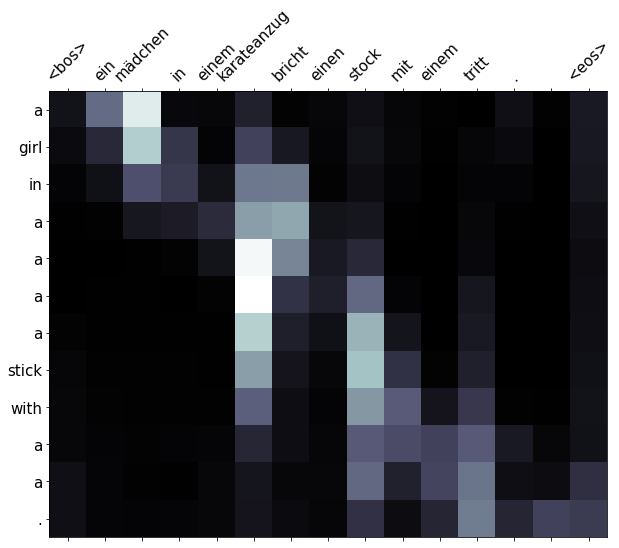

In [ ]:
translation, attention = translate_sentence(model, src.lower())

print('predicted trg = ', ' '.join(translation))

display_attention(src, translation, attention)

In [ ]:
example_idx = 4

src = ' '.join(vars(test_data.examples[example_idx])['src'])
trg = ' '.join(vars(test_data.examples[example_idx])['trg'])

print(f'src = {src}')
print(f'trg = {trg}')

NameError: ignored

In [ ]:
translation, attention = translate_sentence(model, src)

print('predicted trg = ', ''.join(translation))

display_attention(src, translation, attention)